In [1]:
import findspark
findspark.init()
import os
import sys
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueErrorError('spark环境没有配好')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'D:\spark\spark-3.3.0-bin-hadoop3\python\lib\py4j-0.10.9.5-src.zip'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


# SparkSQL的许多功能封装在SparkSession的方法接口中, SparkContext则不行的。
ss = SparkSession.builder \
    .appName("sta321") \
    .config("master", "local[4]") \
    .enableHiveSupport() \
    .getOrCreate()
sc = ss.sparkContext

In [5]:
csvDF=ss.read.csv("TAXI.csv",header=True,inferSchema=True)
csvDF.show()
ID=ss.read.csv("taxi_zones.csv",header=True,inferSchema=True)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---+--------+----+-------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|day|week_day|hour|               date|          duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+---+--------+----+-------------------+------------------+
|       2| 2019-12-02 10:09:59|  2019-12-02 10:50:00

In [6]:
taxi=csvDF.select('PULocationID','DOLocationID','total_amount','congestion_surcharge','hour','week_day','duration')
taxi=taxi.join(ID,taxi.PULocationID ==  ID.LocationID,"inner")
taxi2=taxi.select('Borough','hour','week_day',taxi['total_amount']+taxi['congestion_surcharge'],(taxi['total_amount']+taxi['congestion_surcharge'])/taxi['duration'])
taxi2.show()

+---------+----+--------+-------------------------------------+--------------------------------------------------+
|  Borough|hour|week_day|(total_amount + congestion_surcharge)|((total_amount + congestion_surcharge) / duration)|
+---------+----+--------+-------------------------------------+--------------------------------------------------+
|Manhattan|  10|       2|                                 87.8|                                2.1940857975843397|
|Manhattan|   5|       4|                                 94.8|                                            2.9625|
|Manhattan|  12|       4|                                 65.8|                                 1.602272727272727|
|Manhattan|   0|       1|                                17.86|                                1.8224489795918366|
|Manhattan|   5|       1|                                 19.0|                                1.6101694915254237|
|Manhattan|  11|       1|                                 35.3|                 

In [7]:
taxip=csvDF.select('PULocationID','DOLocationID','total_amount','congestion_surcharge','hour','week_day','duration','trip_distance')
taxip=taxip.join(ID,taxip.PULocationID ==  ID.LocationID,"inner")
taxi3=taxip.select('Borough','hour','week_day',taxip['total_amount']+taxip['congestion_surcharge'],taxip['trip_distance']/taxip['duration'])
taxi3.show()


+---------+----+--------+-------------------------------------+--------------------------+
|  Borough|hour|week_day|(total_amount + congestion_surcharge)|(trip_distance / duration)|
+---------+----+--------+-------------------------------------+--------------------------+
|Manhattan|  10|       2|                                 87.8|        0.4415660141607664|
|Manhattan|   5|       4|                                 94.8|                      0.56|
|Manhattan|  12|       4|                                 65.8|       0.37913961038961036|
|Manhattan|   0|       1|                                17.86|       0.18163265306122447|
|Manhattan|   5|       1|                                 19.0|         0.211864406779661|
|Manhattan|  11|       1|                                 35.3|       0.15422932330827066|
|Manhattan|  16|       1|                   16.060000000000002|       0.13015873015873017|
| Brooklyn|  21|       1|                                 64.8|       0.32926829268292684|

In [8]:
meanspeed=taxi3.groupBy("Borough").mean( "(trip_distance / duration)")
meanspeed.show()

+-------------+-------------------------------+
|      Borough|avg((trip_distance / duration))|
+-------------+-------------------------------+
|       Queens|             0.3620174341905553|
|          EWR|             0.7175437345850345|
|      Unknown|            0.18200282510801336|
|     Brooklyn|            0.21996173061301577|
|Staten Island|             0.4105801159316564|
|    Manhattan|            0.16538789327840905|
|        Bronx|            0.21802703791942382|
+-------------+-------------------------------+



In [9]:
hour1=taxi2.filter(taxi2["hour"]<=6)

In [10]:
mean1=hour1.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean1.show()
#mean1.sort("").show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                      1.774088967367011|
|          EWR|                                     24.904793375308156|
|      Unknown|                                     2.7021583631774306|
|     Brooklyn|                                     1.5927734833809866|
|Staten Island|                                     1.6790617330301103|
|    Manhattan|                                      2.217643828093092|
|        Bronx|                                     1.6856260750761425|
+-------------+-------------------------------------------------------+



In [33]:
average1=taxi2.groupBy("Borough").mean( "(total_amount + congestion_surcharge)")
average1.show()

+-------------+------------------------------------------+
|      Borough|avg((total_amount + congestion_surcharge))|
+-------------+------------------------------------------+
|       Queens|                          35.4058407998138|
|          EWR|                         84.36266666666667|
|      Unknown|                        18.908841595335385|
|     Brooklyn|                          19.2843723002394|
|Staten Island|                         57.53844444444442|
|    Manhattan|                        18.637915848757395|
|        Bronx|                        16.489616106822435|
+-------------+------------------------------------------+



In [11]:
mean1.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|          EWR|                                     24.904793375308156|
|      Unknown|                                     2.7021583631774306|
|    Manhattan|                                      2.217643828093092|
|       Queens|                                      1.774088967367011|
|        Bronx|                                     1.6856260750761425|
|Staten Island|                                     1.6790617330301103|
|     Brooklyn|                                     1.5927734833809866|
+-------------+-------------------------------------------------------+



In [12]:
hour2=taxi2.filter((taxi2["hour"]<=12)&(taxi2["hour"]>6))
mean2=hour2.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean2.show()
#mean1.sort("").show()
mean2.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                     1.4728921712425769|
|          EWR|                                      14.59295636496232|
|      Unknown|                                      1.832470557920207|
|     Brooklyn|                                      1.370343380125859|
|Staten Island|                                     1.5350135190930343|
|    Manhattan|                                      1.818390240687722|
|        Bronx|                                     1.1561321453024658|
+-------------+-------------------------------------------------------+

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+------------------------------------------------

In [13]:
hour3=taxi2.filter((taxi2["hour"]<=18)&(taxi2["hour"]>12))
mean3=hour3.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean3.show()
#mean1.sort("").show()
mean3.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                      1.353290803519617|
|          EWR|                                        58.798265095761|
|      Unknown|                                     1.7040587536259257|
|     Brooklyn|                                     1.2798297972681074|
|Staten Island|                                      4.699310653862463|
|    Manhattan|                                     1.7150942514268743|
|        Bronx|                                      1.051338966409596|
+-------------+-------------------------------------------------------+

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+------------------------------------------------

In [14]:
hour4=taxi2.filter((taxi2["hour"]<=23)&(taxi2["hour"]>18))
mean4=hour2.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean4.show()
#mean1.sort("").show()
mean4.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                     1.4728921712425769|
|          EWR|                                      14.59295636496232|
|      Unknown|                                      1.832470557920207|
|     Brooklyn|                                      1.370343380125859|
|Staten Island|                                     1.5350135190930343|
|    Manhattan|                                      1.818390240687722|
|        Bronx|                                     1.1561321453024658|
+-------------+-------------------------------------------------------+

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+------------------------------------------------

In [15]:
hour5=taxi2.filter(taxi2["week_day"]<=5)
mean5=hour5.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean5.show()
#mean1.sort("").show()
mean5.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                      1.549906516057713|
|          EWR|                                      40.89665592169562|
|      Unknown|                                      1.923251775040594|
|     Brooklyn|                                      1.429488634586421|
|Staten Island|                                      2.673764956358352|
|    Manhattan|                                     1.8522774854096615|
|        Bronx|                                     1.2782627581110022|
+-------------+-------------------------------------------------------+

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+------------------------------------------------

In [16]:
hour6=taxi2.filter(taxi2["week_day"]>5)
mean6=hour6.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
mean6.show()
#mean1.sort("").show()6
mean6.sort("avg(((total_amount + congestion_surcharge) / duration))",ascending=False).show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                     1.4904450005994796|
|          EWR|                                     27.266107969457835|
|      Unknown|                                     1.8563513419447846|
|     Brooklyn|                                     1.4121922472805573|
|Staten Island|                                     1.5309779727808106|
|    Manhattan|                                     1.8017860187556671|
|        Bronx|                                     1.2514927495856383|
+-------------+-------------------------------------------------------+

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+------------------------------------------------

In [17]:
#taxi2.coalesce(1).write.option("header", "true").csv("data2.csv")
#taxi3.coalesce(1).write.option("header", "true").csv("data3.csv")

In [18]:
df=pd.read_csv("part.csv")
#df=df.drop(df["Borough"]=="EWR")
df1=df.drop(index = df[(df.Borough == "EWR")].index.tolist())
df2=df1.drop(index = df[(df.Borough == "Staten Island")].index.tolist())


In [19]:
speed=pd.read_csv("part2.csv")
hourspeed = speed.pivot_table(
    index='Borough',
    columns='hour',
    values='(trip_distance / duration)',
    aggfunc='mean'
)

In [20]:

hours = df.pivot_table(
    index='Borough',
    columns='hour',
    values='((total_amount + congestion_surcharge) / duration)',
    aggfunc='mean'
)
hours1 = df1.pivot_table(
    index='Borough',
    columns='hour',
    values='((total_amount + congestion_surcharge) / duration)',
    aggfunc='mean'
)
hours2 = df2.pivot_table(
    index='Borough',
    columns='hour',
    values='((total_amount + congestion_surcharge) / duration)',
    aggfunc='mean'
)
hourspeed

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Borough,,,,,,,,,,,,,,,,,,,,,
Bronx,0.253042,0.265826,0.303352,0.311777,0.271397,0.310842,0.274682,0.213115,0.206685,0.209747,...,0.179390,0.172206,0.162639,0.160119,0.179242,0.200913,0.208439,0.232572,0.278847,0.270280
Brooklyn,0.244214,0.250279,0.264796,0.273265,0.290926,0.327084,0.286302,0.246792,0.216338,0.209522,...,0.187540,0.189291,0.178249,0.176201,0.182749,0.196925,0.205083,0.215907,0.228823,0.236805
EWR,NaN,NaN,NaN,NaN,1.083333,0.024002,1.862865,0.345783,0.585931,0.450155,...,0.431050,0.293662,0.219045,0.185337,0.837116,0.365573,NaN,2.956522,0.548936,0.338926
Manhattan,0.218054,0.234894,0.247844,0.261682,0.285444,0.277099,0.239858,0.194735,0.165910,0.160769,...,0.139628,0.136449,0.137375,0.137187,0.140875,0.149937,0.163992,0.176384,0.186217,0.200189
Queens,0.474186,0.449943,0.402909,0.390922,0.390427,0.449079,0.381417,0.340532,0.334754,0.348836,...,0.288913,0.272015,0.268546,0.272352,0.304784,0.350589,0.398029,0.422821,0.450198,0.467352
Staten Island,0.532928,0.435419,0.348282,0.478860,0.256723,0.542705,0.626436,0.389093,0.345635,0.385356,...,0.304590,0.305011,0.233825,0.324373,0.414822,0.266684,0.482537,0.243923,0.373244,0.343921
Unknown,0.245548,0.297011,0.356234,0.282802,0.312036,0.286327,0.250018,0.210664,0.179414,0.169120,...,0.147604,0.141766,0.142304,0.151513,0.146540,0.160123,0.185477,0.206349,0.204182,0.221027


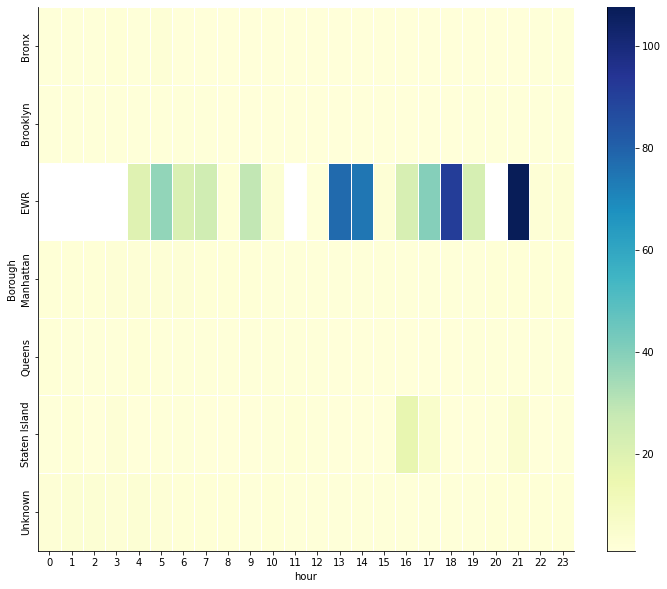

In [21]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

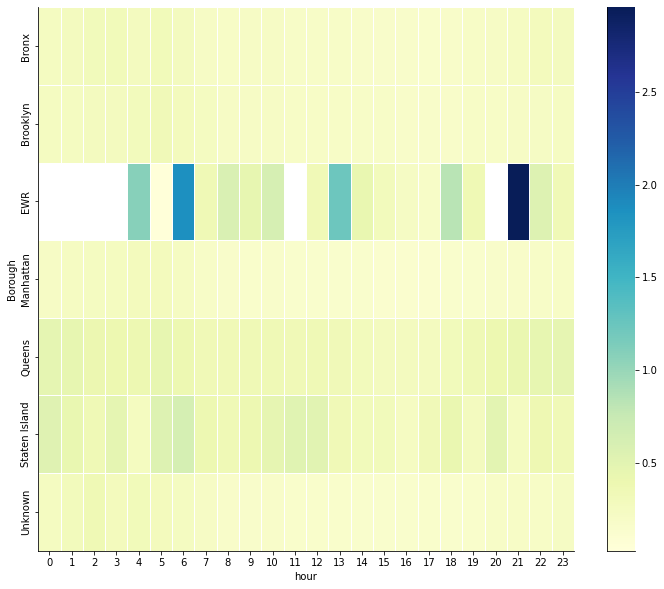

In [22]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hourspeed,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

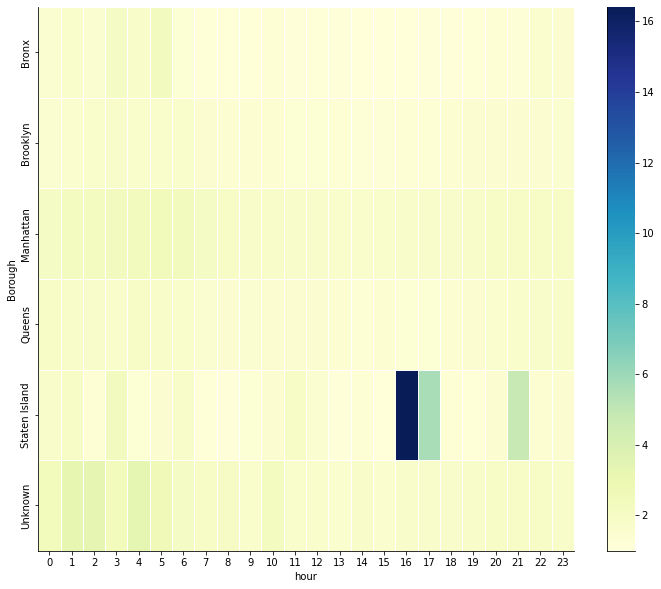

In [23]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours1,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

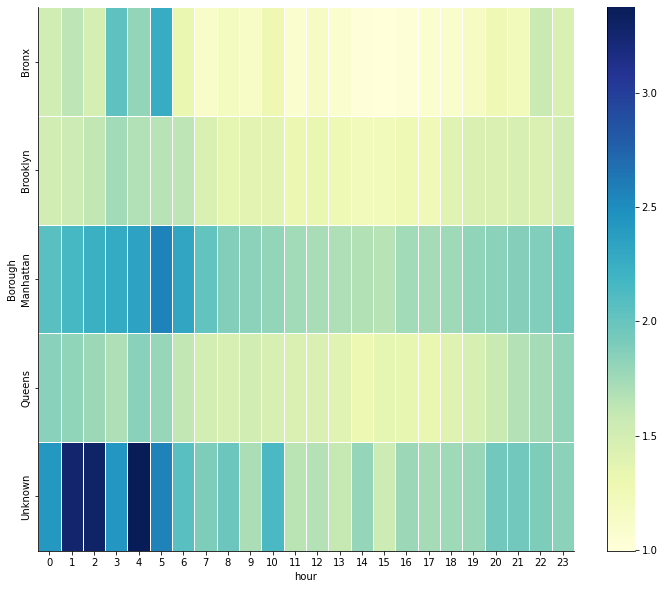

In [24]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours2,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

In [25]:
taxip=csvDF.select('PULocationID','DOLocationID','total_amount','congestion_surcharge','hour','week_day','duration','trip_distance')
taxip=taxip.join(ID,taxip.PULocationID ==  ID.LocationID,"inner")
taxip = taxip.withColumnRenamed('Borough','Boroughp')
taxip = taxip.withColumnRenamed('LocationID','LocationID2')
taxip2=taxip.join(ID,taxip.DOLocationID ==  ID.LocationID,"inner")
taxinew=taxip2.select('Boroughp','Borough')
taxinew.show()
#taxip2.show()

+---------+---------+
| Boroughp|  Borough|
+---------+---------+
|Manhattan|      EWR|
|Manhattan|      EWR|
|Manhattan|      EWR|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
| Brooklyn|Manhattan|
|Manhattan|Manhattan|
|   Queens|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|Manhattan|
|Manhattan|   Queens|
+---------+---------+
only showing top 20 rows



In [26]:
taxipro=taxinew.groupBy("Boroughp","Borough").count()
taxipro.show()

+-------------+-------------+-------+
|     Boroughp|      Borough|  count|
+-------------+-------------+-------+
|     Brooklyn|    Manhattan|  17716|
|          EWR|          EWR|     27|
|     Brooklyn|        Bronx|    150|
|     Brooklyn|          EWR|      9|
|    Manhattan|    Manhattan|5744019|
|     Brooklyn|     Brooklyn|  37534|
|Staten Island|     Brooklyn|     26|
|       Queens|       Queens| 125929|
|       Queens|        Bronx|    306|
|      Unknown|        Bronx|     77|
|       Queens|          EWR|     34|
|Staten Island|       Queens|     33|
|    Manhattan|          EWR|   2298|
|        Bronx|     Brooklyn|     36|
|      Unknown|    Manhattan|  15246|
|     Brooklyn|       Queens|   3516|
|       Queens|Staten Island|     23|
|        Bronx|Staten Island|      8|
|    Manhattan|Staten Island|     54|
|       Queens|      Unknown|   4830|
+-------------+-------------+-------+
only showing top 20 rows



In [27]:
#taxipro.coalesce(1).write.option("header", "true").csv("taxipro.csv")

In [28]:
dfp=pd.read_csv("taxipro.csv")

In [29]:
taxiproh = dfp.pivot_table(
    index='Boroughp',
    columns='Borough',
    values='count',
    aggfunc='mean'
)
taxiproh

Borough,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Unknown
Boroughp,,,,,,,
Bronx,2986.0,36.0,NaN,1699.0,17.0,8.0,47.0
Brooklyn,150.0,37534.0,9.0,17716.0,3516.0,10.0,98.0
EWR,NaN,NaN,27.0,1.0,NaN,NaN,17.0
Manhattan,24082.0,142718.0,2298.0,5744019.0,93904.0,54.0,4331.0
Queens,306.0,61329.0,34.0,41707.0,125929.0,23.0,4830.0
Staten Island,NaN,26.0,NaN,34.0,33.0,79.0,8.0
Unknown,77.0,745.0,67.0,15246.0,896.0,1.0,25492.0


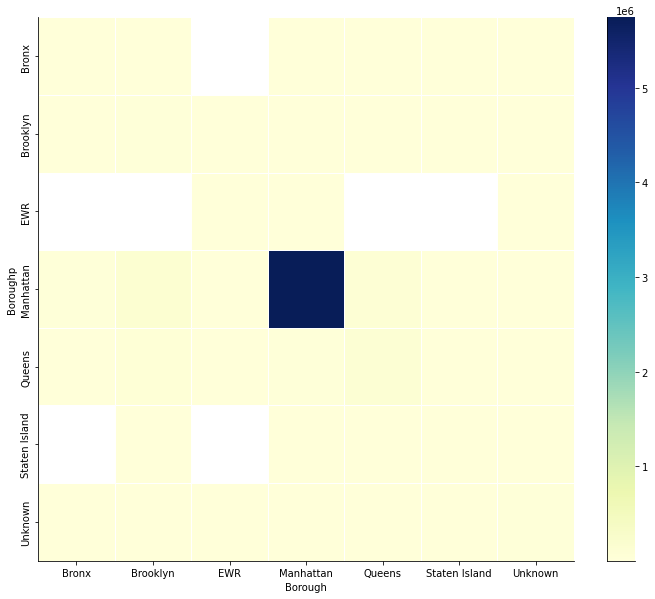

In [30]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=taxiproh,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

In [34]:
hours10 = df.pivot_table(
    index='Borough',
    columns='hour',
    values='(total_amount + congestion_surcharge)',
    aggfunc='mean'
)
hours11 = df1.pivot_table(
    index='Borough',
    columns='hour',
    values='(total_amount + congestion_surcharge)',
    aggfunc='mean'
)
hours12 = df2.pivot_table(
    index='Borough',
    columns='hour',
    values='(total_amount + congestion_surcharge)',
    aggfunc='mean'
)


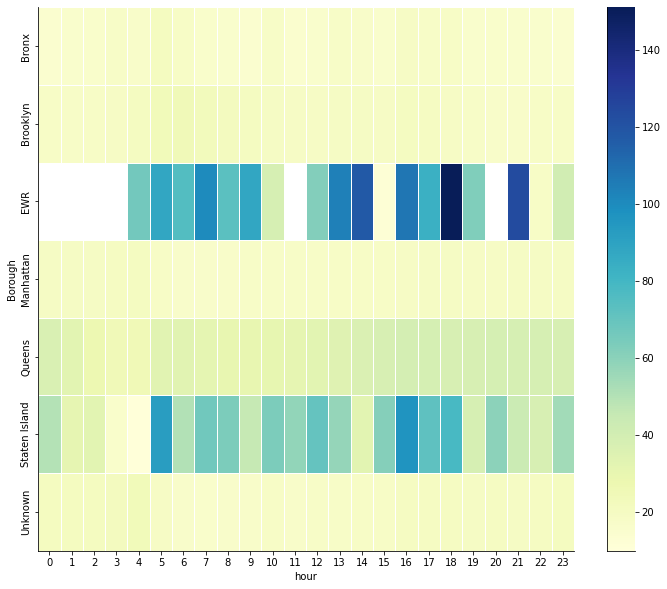

In [36]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours10,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

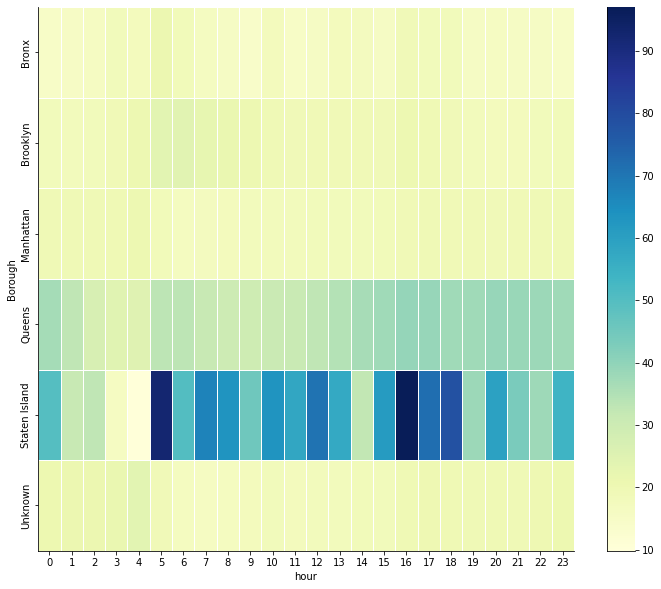

In [37]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours11,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

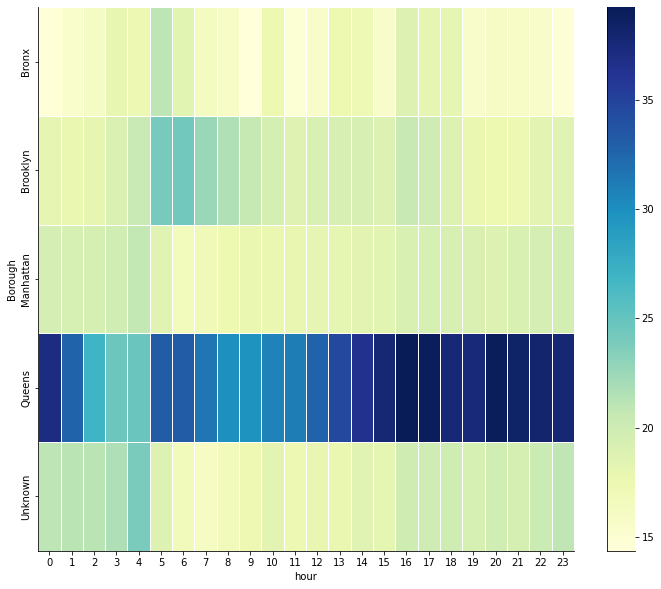

In [38]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=hours12,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()

In [61]:
dfp2=pd.read_csv("taxipro2.csv")
dfp2

,Boroughp,Borough,count,percent
0,Brooklyn,Manhattan,17716,0.300103
1,EWR,EWR,27,0.600000
2,Brooklyn,Bronx,150,0.002540
3,Brooklyn,EWR,9,0.000152
4,Manhattan,Manhattan,5744019,0.906826
5,Brooklyn,Brooklyn,37534,0.635814
6,Staten Island,Brooklyn,26,0.144444
7,Queens,Queens,125929,0.537795
8,Queens,Bronx,306,0.001307
9,Unknown,Bronx,77,0.001811


In [62]:
average2=hour1.groupBy("Borough").mean( "((total_amount + congestion_surcharge) / duration)")
average2.show()

+-------------+-------------------------------------------------------+
|      Borough|avg(((total_amount + congestion_surcharge) / duration))|
+-------------+-------------------------------------------------------+
|       Queens|                                      1.774088967367011|
|          EWR|                                     24.904793375308156|
|      Unknown|                                     2.7021583631774306|
|     Brooklyn|                                     1.5927734833809866|
|Staten Island|                                     1.6790617330301103|
|    Manhattan|                                      2.217643828093092|
|        Bronx|                                     1.6856260750761425|
+-------------+-------------------------------------------------------+



In [45]:
#average2.coalesce(1).write.option("header", "true").csv("data4.csv")

In [63]:
box=pd.read_csv("part3.csv")
box

,Borough,avg(((total_amount + congestion_surcharge) / duration))
0,Queens,1.774089
1,EWR,24.904793
2,Unknown,2.702158
3,Brooklyn,1.592773
4,Staten Island,1.679062
5,Manhattan,2.217644
6,Bronx,1.685626


In [64]:
dfp3=dfp2.merge(box)

In [65]:
dfp3['value']=dfp3['percent']*dfp3['avg(((total_amount + congestion_surcharge) / duration))']
dfp3

,Boroughp,Borough,count,percent,avg(((total_amount + congestion_surcharge) / duration)),value
0,Brooklyn,Manhattan,17716,0.300103,2.217644,0.665522
1,Manhattan,Manhattan,5744019,0.906826,2.217644,2.011017
2,Unknown,Manhattan,15246,0.358527,2.217644,0.795085
3,Staten Island,Manhattan,34,0.188889,2.217644,0.418888
4,Queens,Manhattan,41707,0.178115,2.217644,0.394995
5,Bronx,Manhattan,1699,0.354475,2.217644,0.786100
6,EWR,Manhattan,1,0.022222,2.217644,0.049281
7,EWR,EWR,27,0.600000,24.904793,14.942876
8,Brooklyn,EWR,9,0.000152,24.904793,0.003786
9,Queens,EWR,34,0.000145,24.904793,0.003611


In [66]:
dfp4=dfp3.drop(['Borough','count','percent','avg(((total_amount + congestion_surcharge) / duration))'],axis=1)
dfp4

,Boroughp,value
0,Brooklyn,0.665522
1,Manhattan,2.011017
2,Unknown,0.795085
3,Staten Island,0.418888
4,Queens,0.394995
5,Bronx,0.786100
6,EWR,0.049281
7,EWR,14.942876
8,Brooklyn,0.003786
9,Queens,0.003611


In [83]:
n1=dfp4.groupby(['Boroughp']).sum()
n1.reset_index(inplace=True)
n1.columns=['Borough','value']
n1

,Borough,value
0,Bronx,1.883787
1,Brooklyn,1.796731
2,EWR,16.012972
3,Manhattan,2.090511
4,Queens,1.827976
5,Staten Island,1.831223
6,Unknown,2.522573


In [86]:
dfp5=dfp2.merge(n1)
dfp5['value2']=dfp5['percent']*dfp5['value']
dfp5=dfp5.drop(['Borough','count','percent','value'],axis=1)
n2=dfp5.groupby(['Boroughp']).sum()
n2.reset_index(inplace=True)
n2.columns=['Borough','value']
n2

,Borough,value
0,Bronx,1.962390
1,Brooklyn,1.890345
2,EWR,10.607211
3,Manhattan,1.978024
4,Queens,1.883011
5,Staten Island,1.905349
6,Unknown,2.360398


In [90]:
dfp6=dfp2.merge(n2)
dfp6['value3']=dfp6['percent']*dfp6['value']
dfp6=dfp6.drop(['Borough','count','percent','value'],axis=1)
n3=dfp6.groupby(['Boroughp']).sum()
n3.reset_index(inplace=True)
n3.columns=['Borough','value']
n3

,Borough,value
0,Bronx,1.970917
1,Brooklyn,1.918509
2,EWR,7.299989
3,Manhattan,1.877171
4,Queens,1.913073
5,Staten Island,1.933038
6,Unknown,2.217275


In [91]:
dfp7=dfp2.merge(n3)
dfp7['value3']=dfp7['percent']*dfp7['value']
dfp7=dfp7.drop(['Borough','count','percent','value'],axis=1)
n4=dfp7.groupby(['Boroughp']).sum()
n4.reset_index(inplace=True)
n4.columns=['Borough','value']
n4

,Borough,value
0,Bronx,1.939440
1,Brooklyn,1.907225
2,EWR,5.259345
3,Manhattan,1.785529
4,Queens,1.915235
5,Staten Island,1.929359
6,Unknown,2.091250


In [93]:
dfp8=dfp2.merge(n4)
dfp8['value3']=dfp8['percent']*dfp8['value']
dfp8=dfp8.drop(['Borough','count','percent','value'],axis=1)
n5=dfp8.groupby(['Boroughp']).sum()
n5.reset_index(inplace=True)
n5.columns=['Borough','value']
n5

,Borough,value
0,Bronx,1.886026
1,Brooklyn,1.872078
2,EWR,3.985313
3,Manhattan,1.701258
4,Queens,1.894183
5,Staten Island,1.903600
6,Unknown,1.979421


In [95]:
dfp9=dfp2.merge(n5)
dfp9['value3']=dfp9['percent']*dfp9['value']
dfp9=dfp9.drop(['Borough','count','percent','value'],axis=1)
n6=dfp9.groupby(['Boroughp']).sum()
n6.reset_index(inplace=True)
n6.columns=['Borough','value']
n6

,Borough,value
0,Bronx,1.821400
1,Brooklyn,1.822667
2,EWR,3.176775
3,Manhattan,1.622993
4,Queens,1.856082
5,Staten Island,1.862470
6,Unknown,1.879005


In [97]:
new=pd.read_csv("brough.csv")

In [98]:
new=new.drop(['ID1','ID2'],axis=1)

In [100]:
t=new.groupby(['Borough2','Borough1']).mean()
t.reset_index(inplace=True)
t

,Borough2,Borough1,duration
0,Bronx,Bronx,15.887356
1,Bronx,Brooklyn,42.168750
2,Bronx,Manhattan,31.050843
3,Bronx,Queens,34.197077
4,Bronx,Unknown,25.317451
5,Brooklyn,Bronx,50.450521
6,Brooklyn,Brooklyn,21.054756
7,Brooklyn,Manhattan,35.898843
8,Brooklyn,Queens,31.312173
9,Brooklyn,Staten Island,42.505000


In [103]:
tm = t.pivot_table(
    index='Borough2',
    columns='Borough1',
    values='duration',
    aggfunc='mean'
)

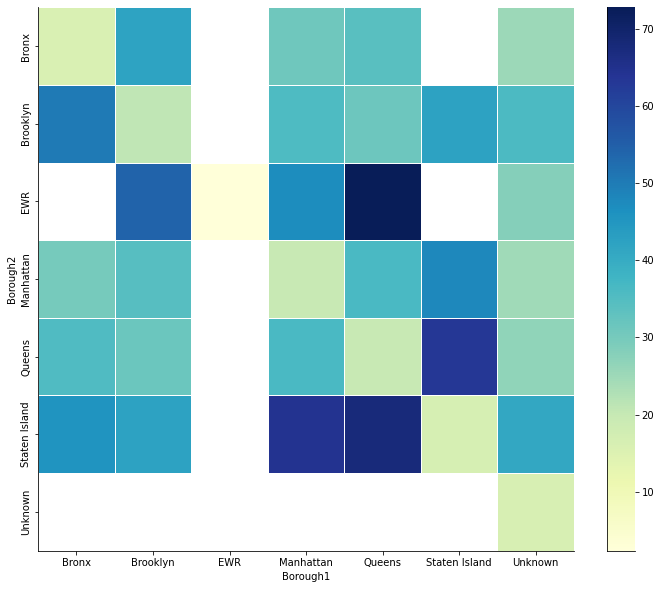

In [104]:
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    data=tm,
    fmt='.1%',
    linewidths=0.5,
    cmap="YlGnBu"
)
#fig.suptitle('', fontsize=15)
sns.despine()
plt.show()